In [61]:
import json

# import os
import sys

import optax
import numpy as np
import jax.numpy as jnp

import jVMC
from jVMC import nets
from jVMC import operator as op
from jVMC import sampler
from jVMC.vqs import NQS
# from jVMC.util import h5SaveParams, NaturalGradient
import h5py as h5

# plotting
import matplotlib.pyplot as plt

import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.random as jrnd

from tqdm import tqdm

In [115]:
N = 4
L = 4
ldim = N+1
homFock = jnp.ones((1,1,L),dtype=int)
oneSiteFockStates = jnp.expand_dims(jnp.eye(L,dtype=int)*N,0)
J = 1.
U = 0.
H = jVMC.operator.bosons.BoseHubbard_Hamiltonian1D(L,J,U,lDim=ldim)

depth_RWKV = 4
emb_RWKV =16
hidden_size=8
num_heads = 1

ebDim = 16
dep = 3
nH = 4

net = jVMC.nets.RpxRWKV(L,LocalHilDim=ldim,hidden_size=hidden_size,num_heads=num_heads,embedding_size=emb_RWKV,num_layers=depth_RWKV,)
net = jVMC.nets.bosons.gpt_stupid.GPT(L,ldim,embeddingDim=ebDim,depth=dep,nHeads=nH)
seed = 252
key2 = jrnd.PRNGKey(seed)
numSamp = 2**8

gum_net = jVMC.nets.gumbel_wrapper(net)
par_net = jVMC.nets.particle_conservation(net,N)

gum_par_net = jVMC.nets.gumbel_wrapper(par_net)

sym= jVMC.util.symmetries.get_orbit_1D(L,"reflection","translation")
sym_net = jVMC.nets.sym_wrapper.SymNet(sym,net,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)

sym_par_net = jVMC.nets.sym_wrapper.SymNet(sym,par_net,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)


sym_gum_par_net = jVMC.nets.sym_wrapper.SymNet(sym,gum_par_net,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)

psi_net= jVMC.vqs.NQS(sym_par_net,seed=seed,batchSize=1024)

sampler_net = jVMC.sampler.MCSampler(psi_net,(L,),key2)



[]

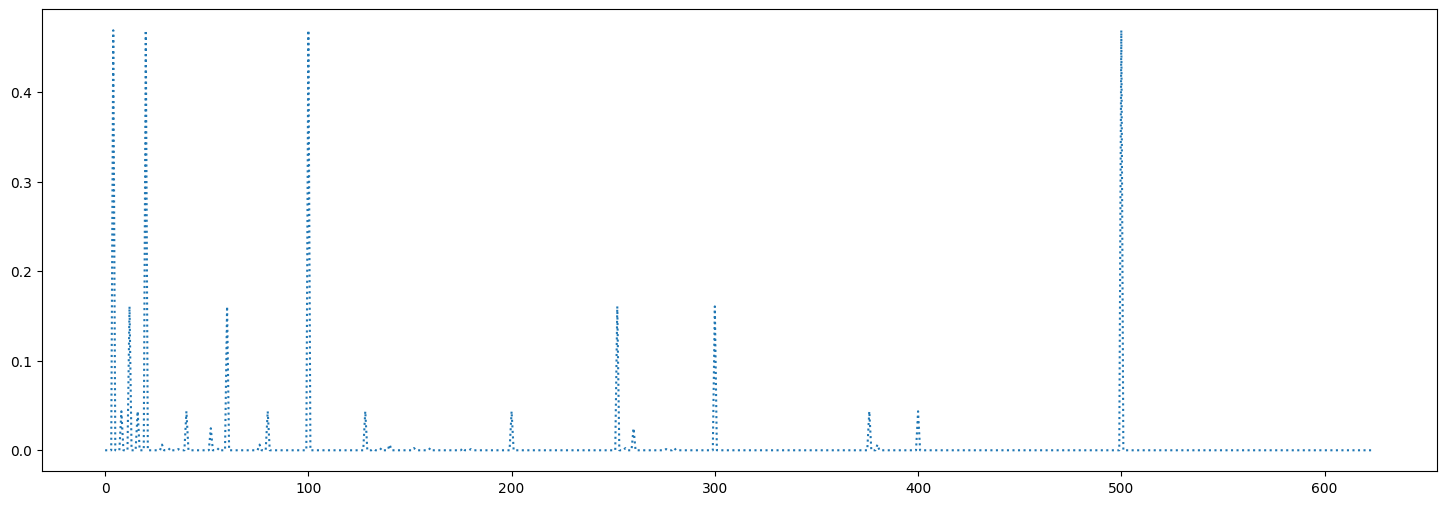

In [116]:
EpsiSampler = jVMC.sampler.ExactSampler(psi_net, (L,),lDim=ldim)
psi_s, psi_logPsi, psi_p = EpsiSampler.sample()
var_wf = np.abs(np.exp(psi_logPsi))[0]
var_wf /= var_wf.dot(var_wf)**0.5

figure = plt.figure(dpi=100, figsize=(18, 6))
#plt.plot(data_at_time)#np.e?xp(chi(psi_s))[0]/sum(np.exp(2.*chi(psi_s))[0])**0.5)
# plt.plot(data_at_time)
plt.plot(var_wf,':')
#plt.plot(data_at_time)
#plt.ylim(0,.7)
plt.plot()

In [120]:
numSamples = 2**8
repeats = 100
sampled_s, psi_logPsi, psi_p = sampler_net.sample(numSamples=numSamples)
sampled_s,psi_logPsi
psi_histogram = (ldim**(L-jnp.arange(L)-1)*sampled_s[0]).sum(axis=-1)
weights = psi_p[0]
for i in range(repeats-1):
    sampled_s, psi_logPsi, psi_p = sampler_net.sample(numSamples=numSamples)
    sampled_s,psi_logPsi
    psi_histogram = jnp.concatenate((psi_histogram,(ldim**(L-jnp.arange(L)-1)*sampled_s[0]).sum(axis=-1)))
    weights = jnp.concatenate((weights,psi_p[0]))


In [121]:
weights.shape,psi_histogram.shape

((25600,), (25600,))

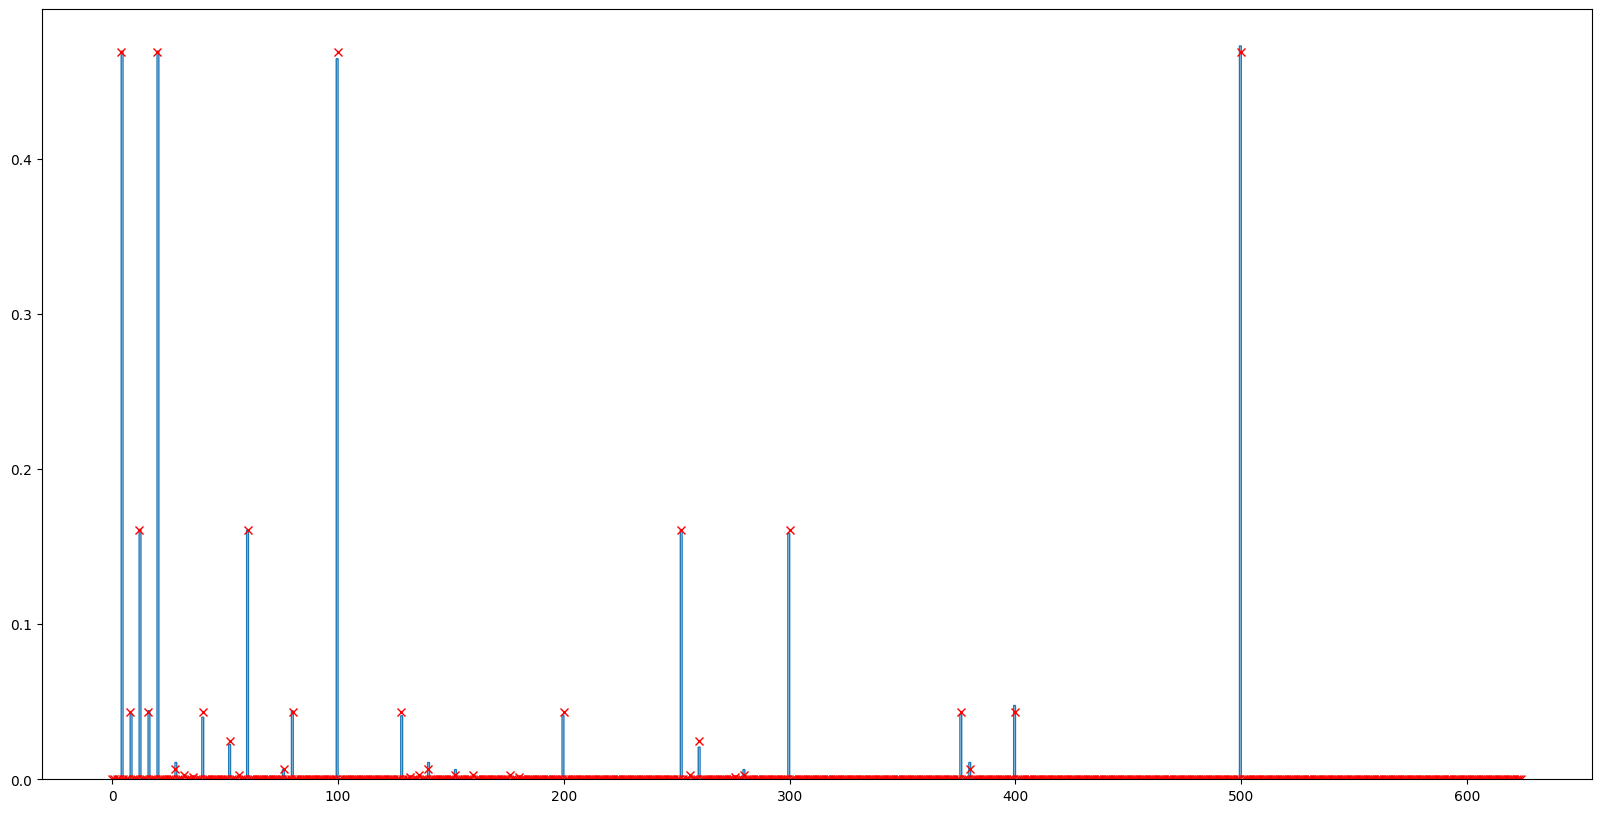

In [122]:

fig = plt.figure(dpi=100, figsize=(20, 10))
const = 0#0.00001
counts, bins = np.histogram(psi_histogram,weights=weights,bins=ldim**L)
#counts, bins = np.histogram(psi_histogram,bins=ldim**L)

plt.stairs(jnp.sqrt(counts/sum(counts))+const, bins)
#plt.stairs(chi_counts/max(chi_counts), chi_bins)
plt.plot(var_wf+const,'x',c='r')
#plt.semilogy()

In [123]:
key = jrnd.PRNGKey(1)
key2 = jrnd.PRNGKey(1)

lr_SR = 1e-2
minSR_equation = jVMC.util.MinSR(sampler_net, makeReal='real',diagonalShift=1e-3,diagonalMulti=1e-3)
stepperSR = jVMC.util.stepper.Euler(timeStep=lr_SR)  
renormalisation = None # 0.1

In [124]:
training_steps= 300
resTraining = np.zeros((training_steps,2))
resTraining_gumbel = np.zeros((training_steps,2))


pbar = tqdm(range(training_steps))
for n,p in enumerate(pbar):
    
    dpOld = psi_net.get_parameters()        
    
    #print(dpOld)
    #dpOld = psi.get_parameters()            
    n_p = jnp.linalg.norm(dpOld)
    dp    = minSR_equation(dpOld,0,hamiltonian=H, psi=psi_net,intStep=0)
    dp = jnp.nan_to_num(dp,0.)
    #for i in range(repeats):
    #    dp_add  = equations(dpOld,0,hamiltonian=H, psi=psi,intStep=0)
    #    dp += jnp.nan_to_num(dp_add,0.)
    #dp /= repeats
    n_grad = jnp.linalg.norm(dp)

    if renormalisation is not None:
        dp = renormalisation *dp/n_grad
    
    #dp, _ = stepperSR.step(0, equations, dpOld, hamiltonian=H, psi=psi)
    psi_net.set_parameters(dpOld + lr_SR * jnp.real(dp))
    resTraining[n] = [jnp.real(minSR_equation.ElocMean0) , minSR_equation.ElocVar0 ]
    #print(dp)
    
    pbar.set_description(f"energy: {resTraining[n][0]:.4f}+-{np.sqrt(resTraining[n][1]):.4f}")
    


energy: -8.0000+-0.0001: 100%|██████████| 300/300 [03:22<00:00,  1.48it/s]


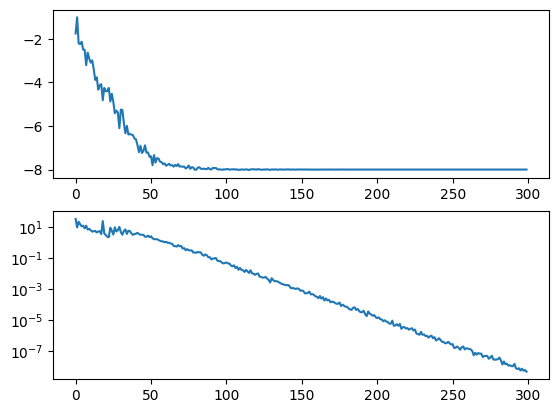

In [128]:
fig,ax = plt.subplots(2)
ax[0].plot(resTraining[:,0])
ax[1].semilogy(resTraining[:,1])


[]

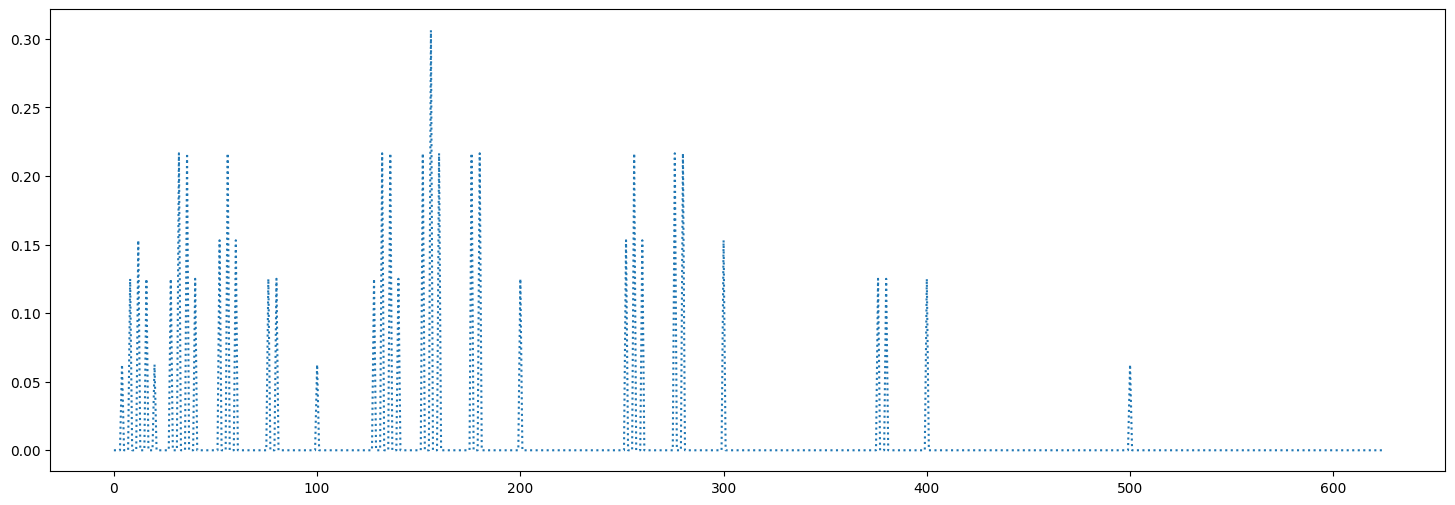

In [125]:
EpsiSampler = jVMC.sampler.ExactSampler(psi_net, (L,),lDim=ldim)
psi_s, psi_logPsi, psi_p = EpsiSampler.sample()
var_wf = np.abs(np.exp(psi_logPsi))[0]
var_wf /= var_wf.dot(var_wf)**0.5

figure = plt.figure(dpi=100, figsize=(18, 6))
#plt.plot(data_at_time)#np.e?xp(chi(psi_s))[0]/sum(np.exp(2.*chi(psi_s))[0])**0.5)
# plt.plot(data_at_time)
plt.plot(var_wf,':')
#plt.plot(data_at_time)
#plt.ylim(0,.7)
plt.plot()

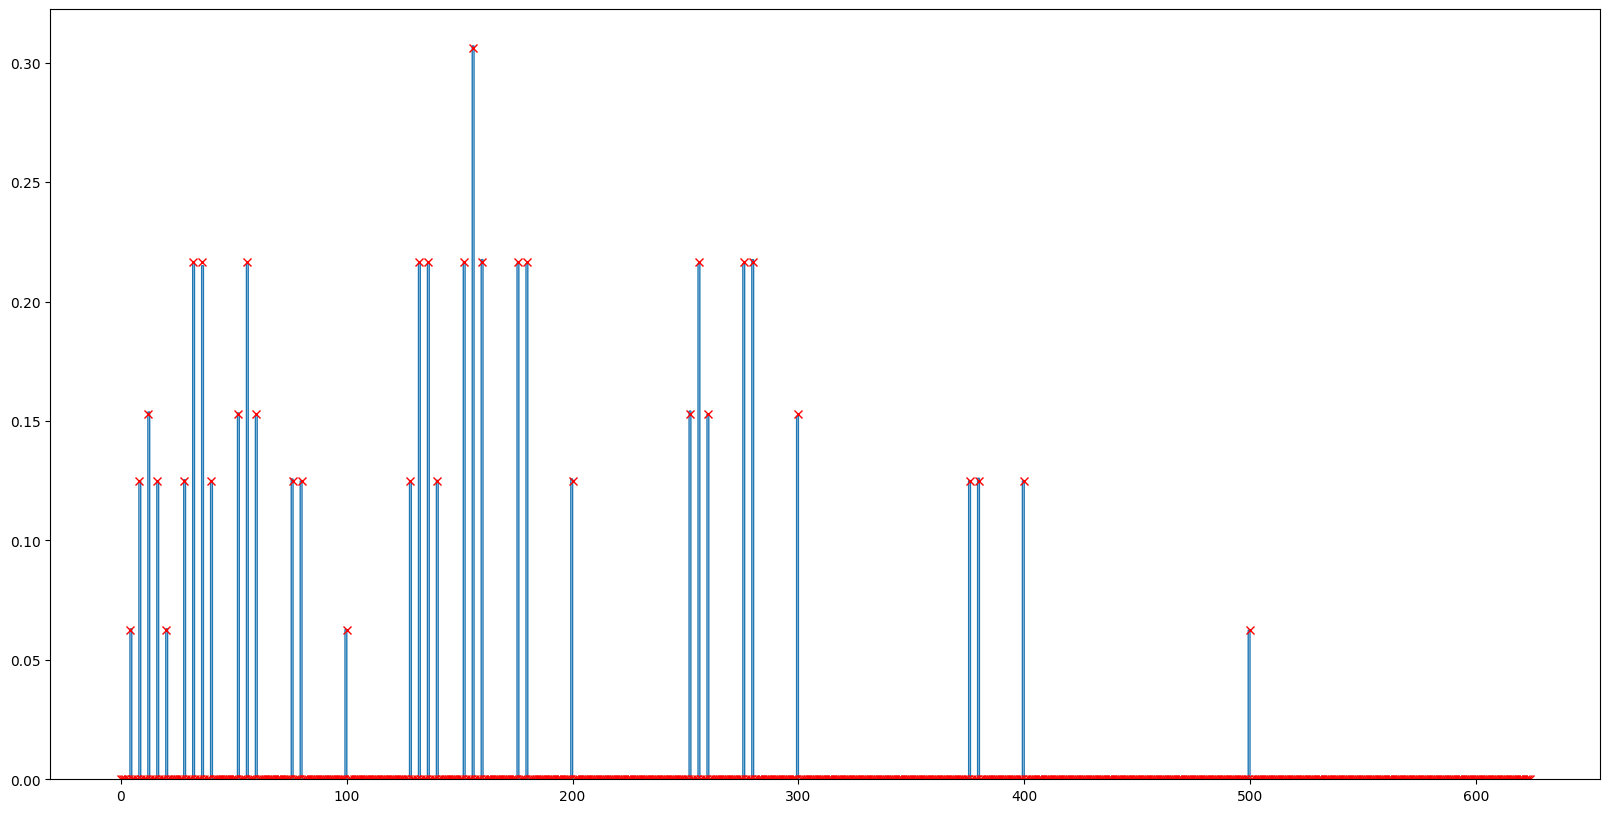

In [126]:
numSamples = 2**19
sampled_s, psi_logPsi, psi_p = sampler_net.sample(numSamples=numSamples)
sampled_s,psi_logPsi
psi_histogram = (ldim**(L-jnp.arange(L)-1)*sampled_s[0]).sum(axis=-1)
fig = plt.figure(dpi=100, figsize=(20, 10))
const = 0#0.00001
counts, bins = np.histogram(psi_histogram,bins=ldim**L)
plt.stairs(jnp.sqrt(counts/sum(counts))+const, bins)
#plt.stairs(chi_counts/max(chi_counts), chi_bins)
plt.plot(var_wf+const,'x',c='r')
#plt.semilogy()

In [127]:
1/(2**14/len(var_wf))

0.03814697265625